# Classifier for YouTube titles

In [1]:
#
# Classifier demo
#
# Some code are derived from
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline
sns.set()

# scikit-learn utility functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# different classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [13]:
#
# Preparation of data
# Read from the pre-generated data and create feature vectors in dataframe
#

INPUT = 'feat.pickle'
feat = pickle.load(open(INPUT, "rb"))
# all possible keys in the feature dictionaries
# feat: list of list of dict, each list of dict is for one headline
# keys: sample of key-value from features
# tags: Lo, Ll, Lu, Lstr, etc.
allfeat = [y for x in feat for y in x]
keys = {k:v for y in allfeat for k,v in y.items()}
tags = {y["tag"] for x in feat for y in x}

# vectorize features
# labels (author, or title) is a single character, and boolean for whether it has literal tag
featvect = []
for f in allfeat:
    f = dict(f)  # copy the dict
    f['label'] = f.get('label') or 'x'  # a, t, or x
    f['Lstr'] = f['tag'].startswith('L')
    featvect.append(f)

# convert into pandas dataframe (converted most to int)
# add derived features
# non-int cols: str, label, tag are strings
df = pd.DataFrame(featvect).rename(columns={'《》':"angle", '（）':"paren", '【】':"square", '“”':"quote"})
df["ftok"] += 1  # ftok and btok: convert from 0-indexed to 1-indexed
df["btok"] += 1
incol = [c for c in df.columns if c not in ['str', 'label', 'tag', 'name']]
df[incol] = df[incol].fillna(0).astype('int')

# additional features derived
df["tokpct"] = df["ftok"]/(df["ftok"] + df["btok"] - 1)
df["lenpct"] = (df["flen"]+df["slen"])/(df["flen"] + df["blen"] + df["slen"])
incol += ["tokpct", "lenpct"]

# gather all numeric, non-boolean columns for scaling
numcols = ['titlen', 'ftok', 'btok', 'flen', 'blen', 'slen', 'fzhtok', 'bzhtok', "tokpct", "lenpct"]
scalecols = ['titlen', 'ftok', 'btok', 'flen', 'blen', 'slen']
incol = [c for c in incol if c in numcols] + sorted([c for c in incol if c not in numcols])
if False:
    # Scale transform vectors before learning
    scaler = StandardScaler()
    scaler.fit(df[scalecols])
    df[scalecols] = scaler.transform(df[scalecols])

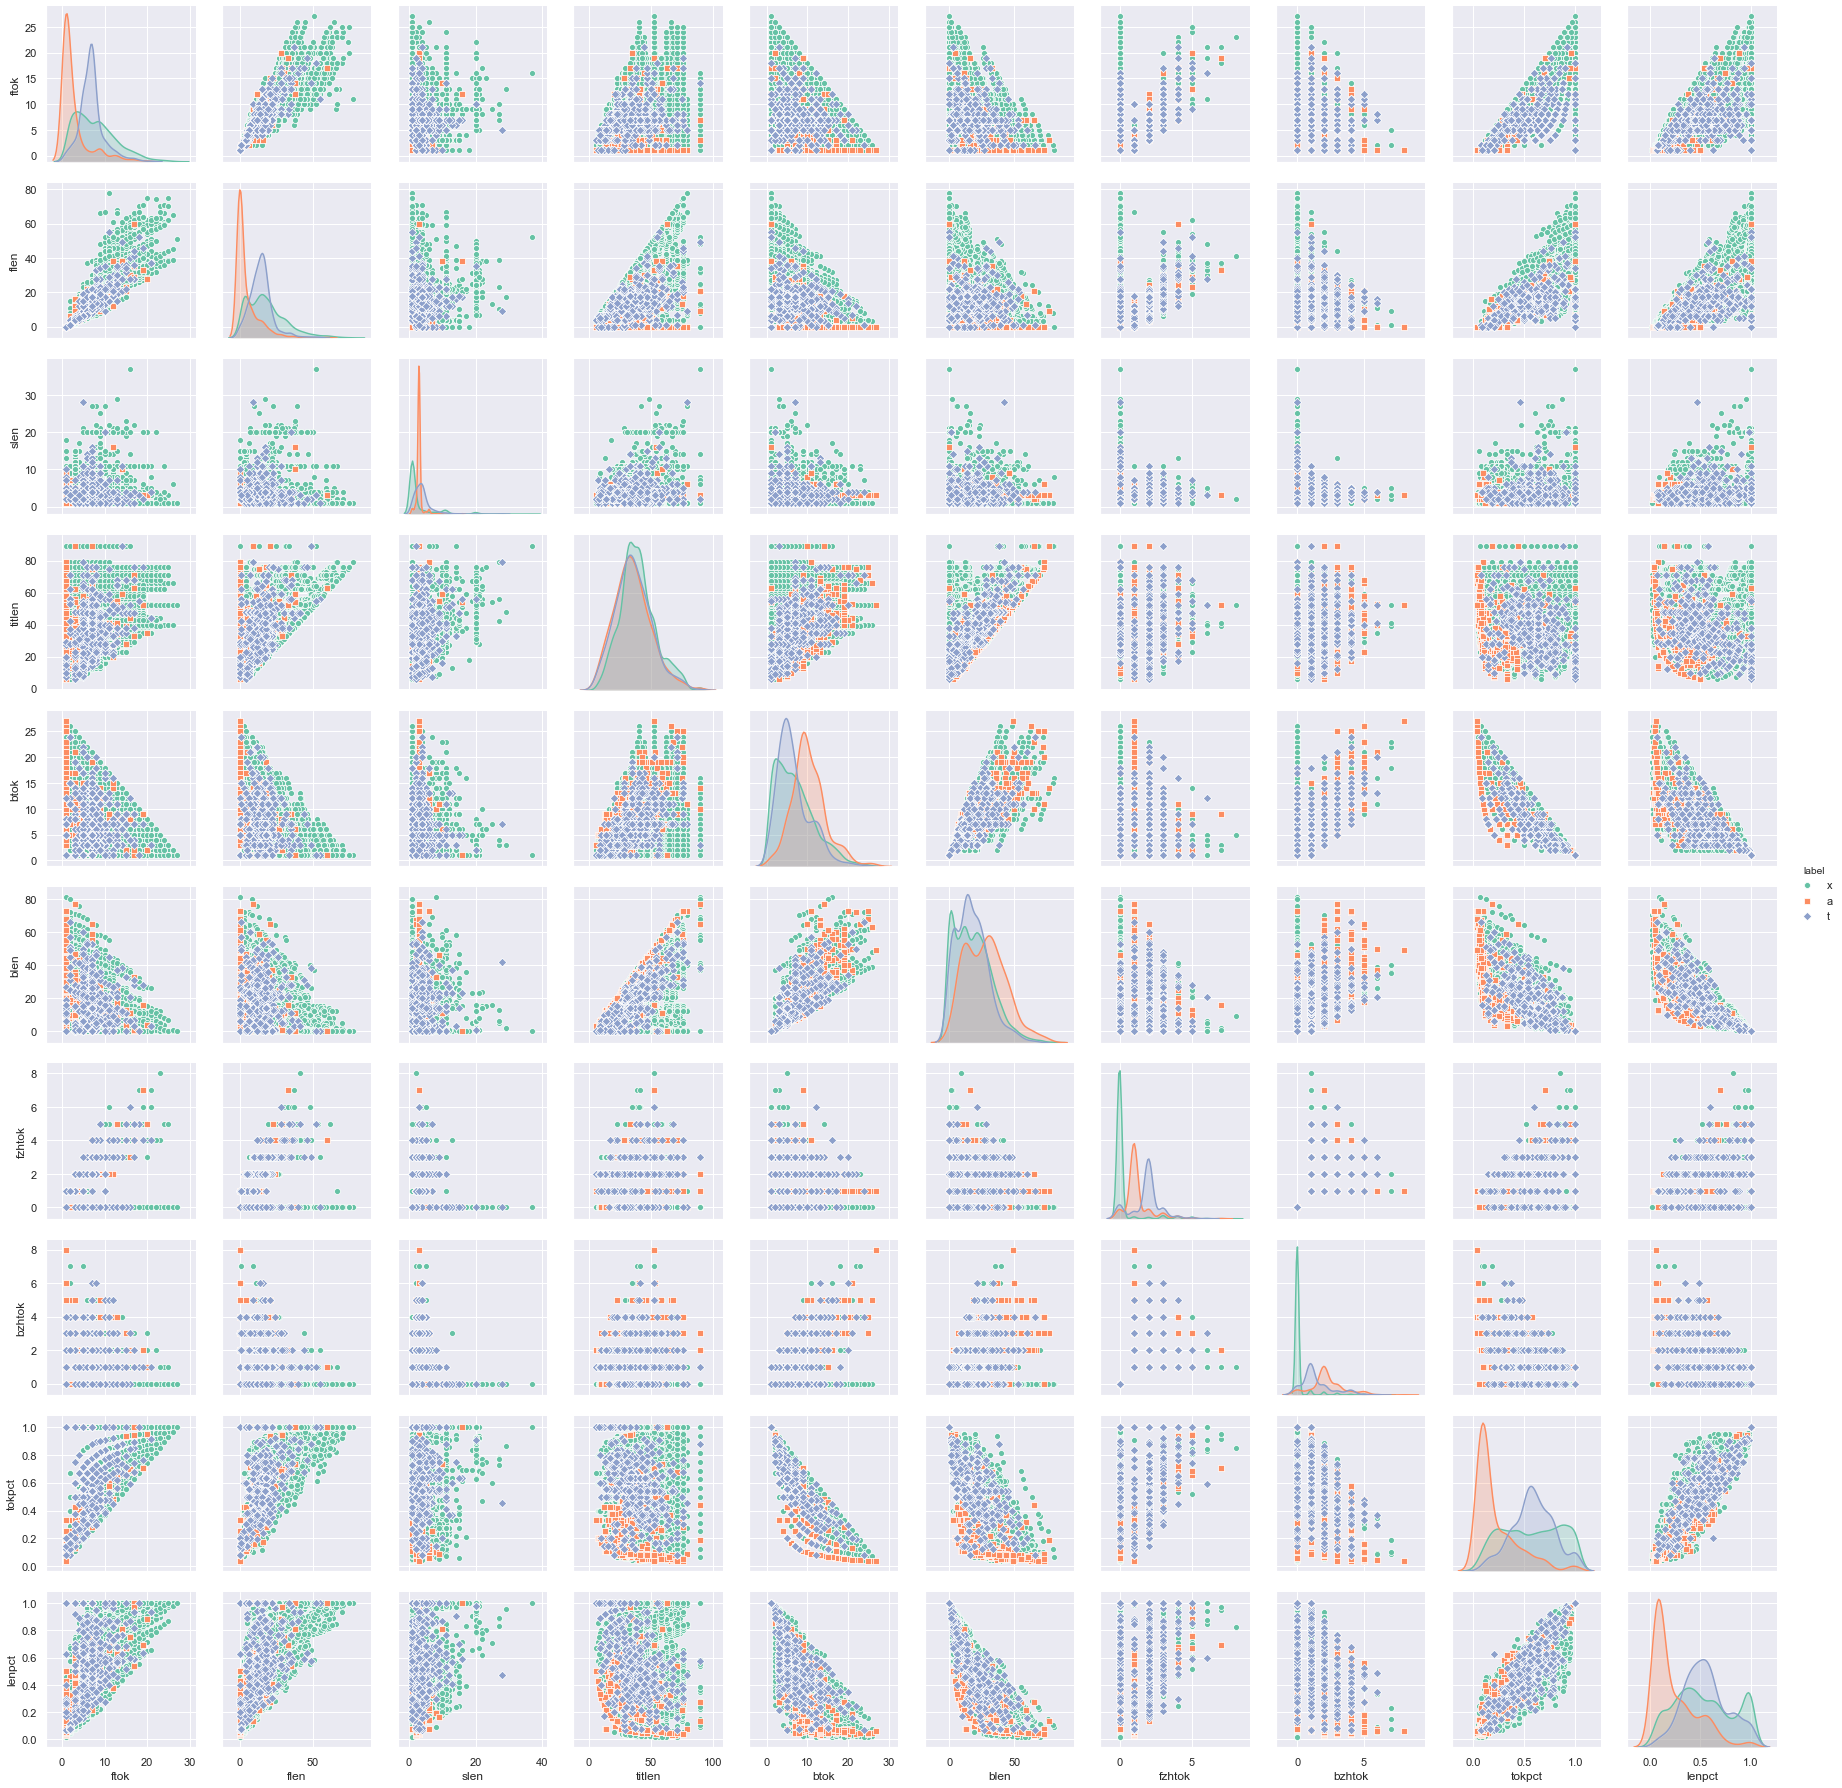

In [3]:
#
# Visual check: Correlogram of features
# this will take some noticeable time to run
#

if True:
    cols = ['label'] + incol
    sns.pairplot(df[cols[:11]], kind="scatter", hue="label", markers=["o", "s", "D"], palette="Set2")
    plt.show()

In [14]:
#
# Numeric check: Correlation coefficient of features to labels
# Here we build each label as an boolean column (valued 0 or 1) and find the
# correlation coefficient matrix of a label column appended by all input feature
# columns, then pick the first row into the new dataframe
#
index = ["a", "t", "x"]
for label in index:
    df[label] = df['label'].eq(label).astype(int)

# Dataframe of correlation coefficients
corrcoef = pd.DataFrame({label: np.corrcoef(df[[label] + incol].T)[0][1:] for label in index}, index=incol).T

# print the correlation coefficients with small values masked out
print(corrcoef.mask(corrcoef.abs().lt(0.1), np.nan).dropna(axis=1, how='all').to_string(float_format="{:.2f}".format))

   ftok  flen  titlen  btok  blen  fzhtok  bzhtok  tokpct  lenpct   ()  Lstr   []  angle  dashafter  dashbefore  square  stopword
a -0.30 -0.30     nan  0.20  0.19    0.23    0.54   -0.35   -0.30  nan  0.38  nan    nan       0.21       -0.20     nan       nan
t   nan   nan     nan   nan   nan    0.44    0.31     nan     nan  nan  0.35  nan   0.57        nan        0.11    0.12       nan
x  0.23  0.26    0.11 -0.11 -0.11   -0.50   -0.64    0.22    0.19 0.14 -0.54 0.11  -0.38        nan         nan     nan      0.12


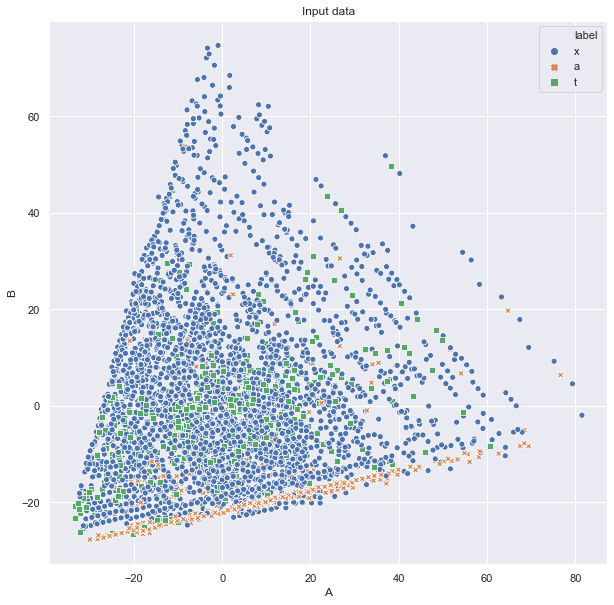

In [5]:
#
# Run PCA to get two features
# the engine can later run (pca.transform(X)) to transform input for nice plotting afterwards
#
pca = PCA(n_components=2)
pca.fit(df[incol])
if True:
    plt.figure(figsize=(10,10))
    ax = sns.scatterplot(data=pd.DataFrame(pca.transform(df[incol]), columns=["A","B"]).assign(label=df["label"]),
                         hue="label", style="label", x="A", y="B")
    ax.set_title("Input data")
    plt.show()

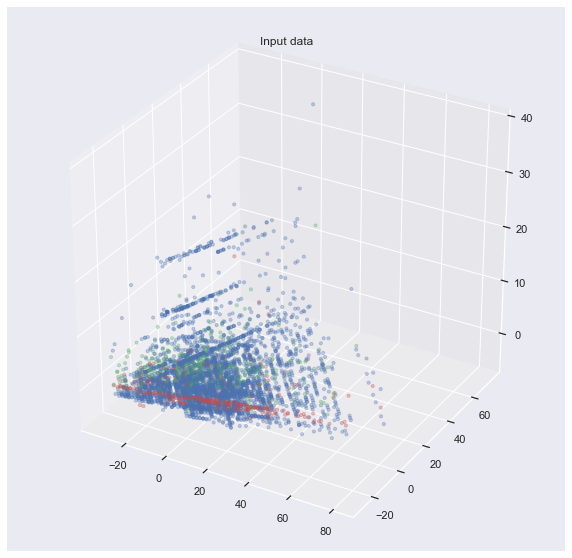

In [26]:
pca = PCA(n_components=3)
pca.fit(df[incol])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
xyz = pd.DataFrame(pca.transform(df[incol]), columns=["X","Y","Z"])
color = df["label"].replace({'a':'r', 't':'g', 'x':'b'})
ax.scatter(xyz["X"], xyz["Y"], xyz["Z"], c=color, s=10, alpha=0.3)
ax.set_title("Input data")
plt.show()

In [6]:
#
# Define classifiers
#

N = 200  # density in the mesh

classifiers = [
     ("Logistic regression", LogisticRegression(solver="newton-cg", max_iter=1000, C=1, multi_class="ovr"))
    ,("Nearest Neighbors", KNeighborsClassifier(3))
    ,("Linear SVM", SVC(kernel="linear", C=0.025))
    ,("RBF SVM", SVC(gamma=2, C=1))
    ,("Decision Tree", DecisionTreeClassifier(max_depth=5))
    ,("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))
    ,("Neural Net", MLPClassifier(alpha=0.01, activation="logistic", max_iter=1000))
    ,("AdaBoost", AdaBoostClassifier())
    ,("Naive Bayes", GaussianNB())
    ,("QDA", QuadraticDiscriminantAnalysis())
    ,("Gaussian Process", GaussianProcessClassifier(1.0 * RBF(1.0)))
]

In [7]:
#
# Prepare for plotting and classification
# Plot using PCA axis
#

X = df[incol]
y = df['label']

pca = PCA(n_components=2)
pca.fit(X)

# get size limit of input data, for plotting purpose
Xpca = pca.transform(X)
x_min, x_max = Xpca[:, 0].min() - .5, Xpca[:, 0].max() + .5
y_min, y_max = Xpca[:, 1].min() - .5, Xpca[:, 1].max() + .5

# build a meshgrid according to input attributes, for plotting
# this takes a while to complete the last for-loop
ranges = []
for c in incol:
    if c in numcols:  # numeric cols
        ranges.append(np.linspace(df[c].min(), df[c].max(), 10))
    else:  # boolean cols
        ranges.append(np.linspace(0, 1, 2))
if False:
    # full mesh grid, this would be too much
    grids = np.meshgrid(*ranges)
    griddf = pd.DataFrame(np.column_stack(tuple(g.ravel() for g in grids)), columns=incol)
    gridpca = pca.transform(griddf)
else:
    # memory-save way to generate some data points to plot contour
    griddf = pd.DataFrame([[np.random.choice(x) for x in ranges] for _ in range(5*N*N)], columns=incol)
    gridpca = pca.transform(griddf)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
zindex = np.ndarray(xx.shape, dtype=int)
for index in np.ndindex(*xx.shape):
    dist = np.linalg.norm(gridpca - np.array([xx[index], yy[index]]), axis=1)
    zindex[index] = np.argmin(dist)

# alternative: use two most discriminative features
featx, featy = corrcoef.abs().max().sort_values(ascending=False).index[:2]

# Create plot helper
def plot(X, y, axis, title, **kwargs):
    "Plot PCA-ized X over label Y in 2D scatter plot"
    ax = sns.scatterplot(data=pd.DataFrame(pca.transform(X), columns=["A","B"]).assign(label=y),
                         hue="label", style="label", x="A", y="B", ax=axis, **kwargs)
    ax.set_title(title)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))


----
Logistic regression (score=0.95851):
              precision    recall  f1-score   support

           a    0.93154   0.87185   0.90071       437
           t    0.88412   0.86013   0.87196       479
           x    0.97167   0.98204   0.97683      3842

    accuracy                        0.95965      4758
   macro avg    0.92911   0.90467   0.91650      4758
weighted avg    0.95917   0.95965   0.95928      4758


----
Nearest Neighbors (score=0.91334):
              precision    recall  f1-score   support

           a    0.79775   0.81236   0.80499       437
           t    0.84069   0.71608   0.77339       479
           x    0.95877   0.97449   0.96657      3842

    accuracy                        0.93359      4758
   macro avg    0.86574   0.83431   0.84832      4758
weighted avg    0.93209   0.93359   0.93228      4758


----
Linear SVM (score=0.95011):
              precision    recall  f1-score   support

           a    0.94279   0.86728   0.90346       437
           

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:720: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (


----
QDA (score=0.08824):
              precision    recall  f1-score   support

           a    0.09185   1.00000   0.16824       437
           t    0.00000   0.00000   0.00000       479
           x    0.00000   0.00000   0.00000      3842

    accuracy                        0.09185      4758
   macro avg    0.03062   0.33333   0.05608      4758
weighted avg    0.00844   0.09185   0.01545      4758



/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:720: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])



----
Gaussian Process (score=0.95746):
              precision    recall  f1-score   support

           a    0.90974   0.87643   0.89277       437
           t    0.90021   0.88518   0.89263       479
           x    0.97491   0.98100   0.97794      3842

    accuracy                        0.96175      4758
   macro avg    0.92829   0.91420   0.92112      4758
weighted avg    0.96140   0.96175   0.96153      4758



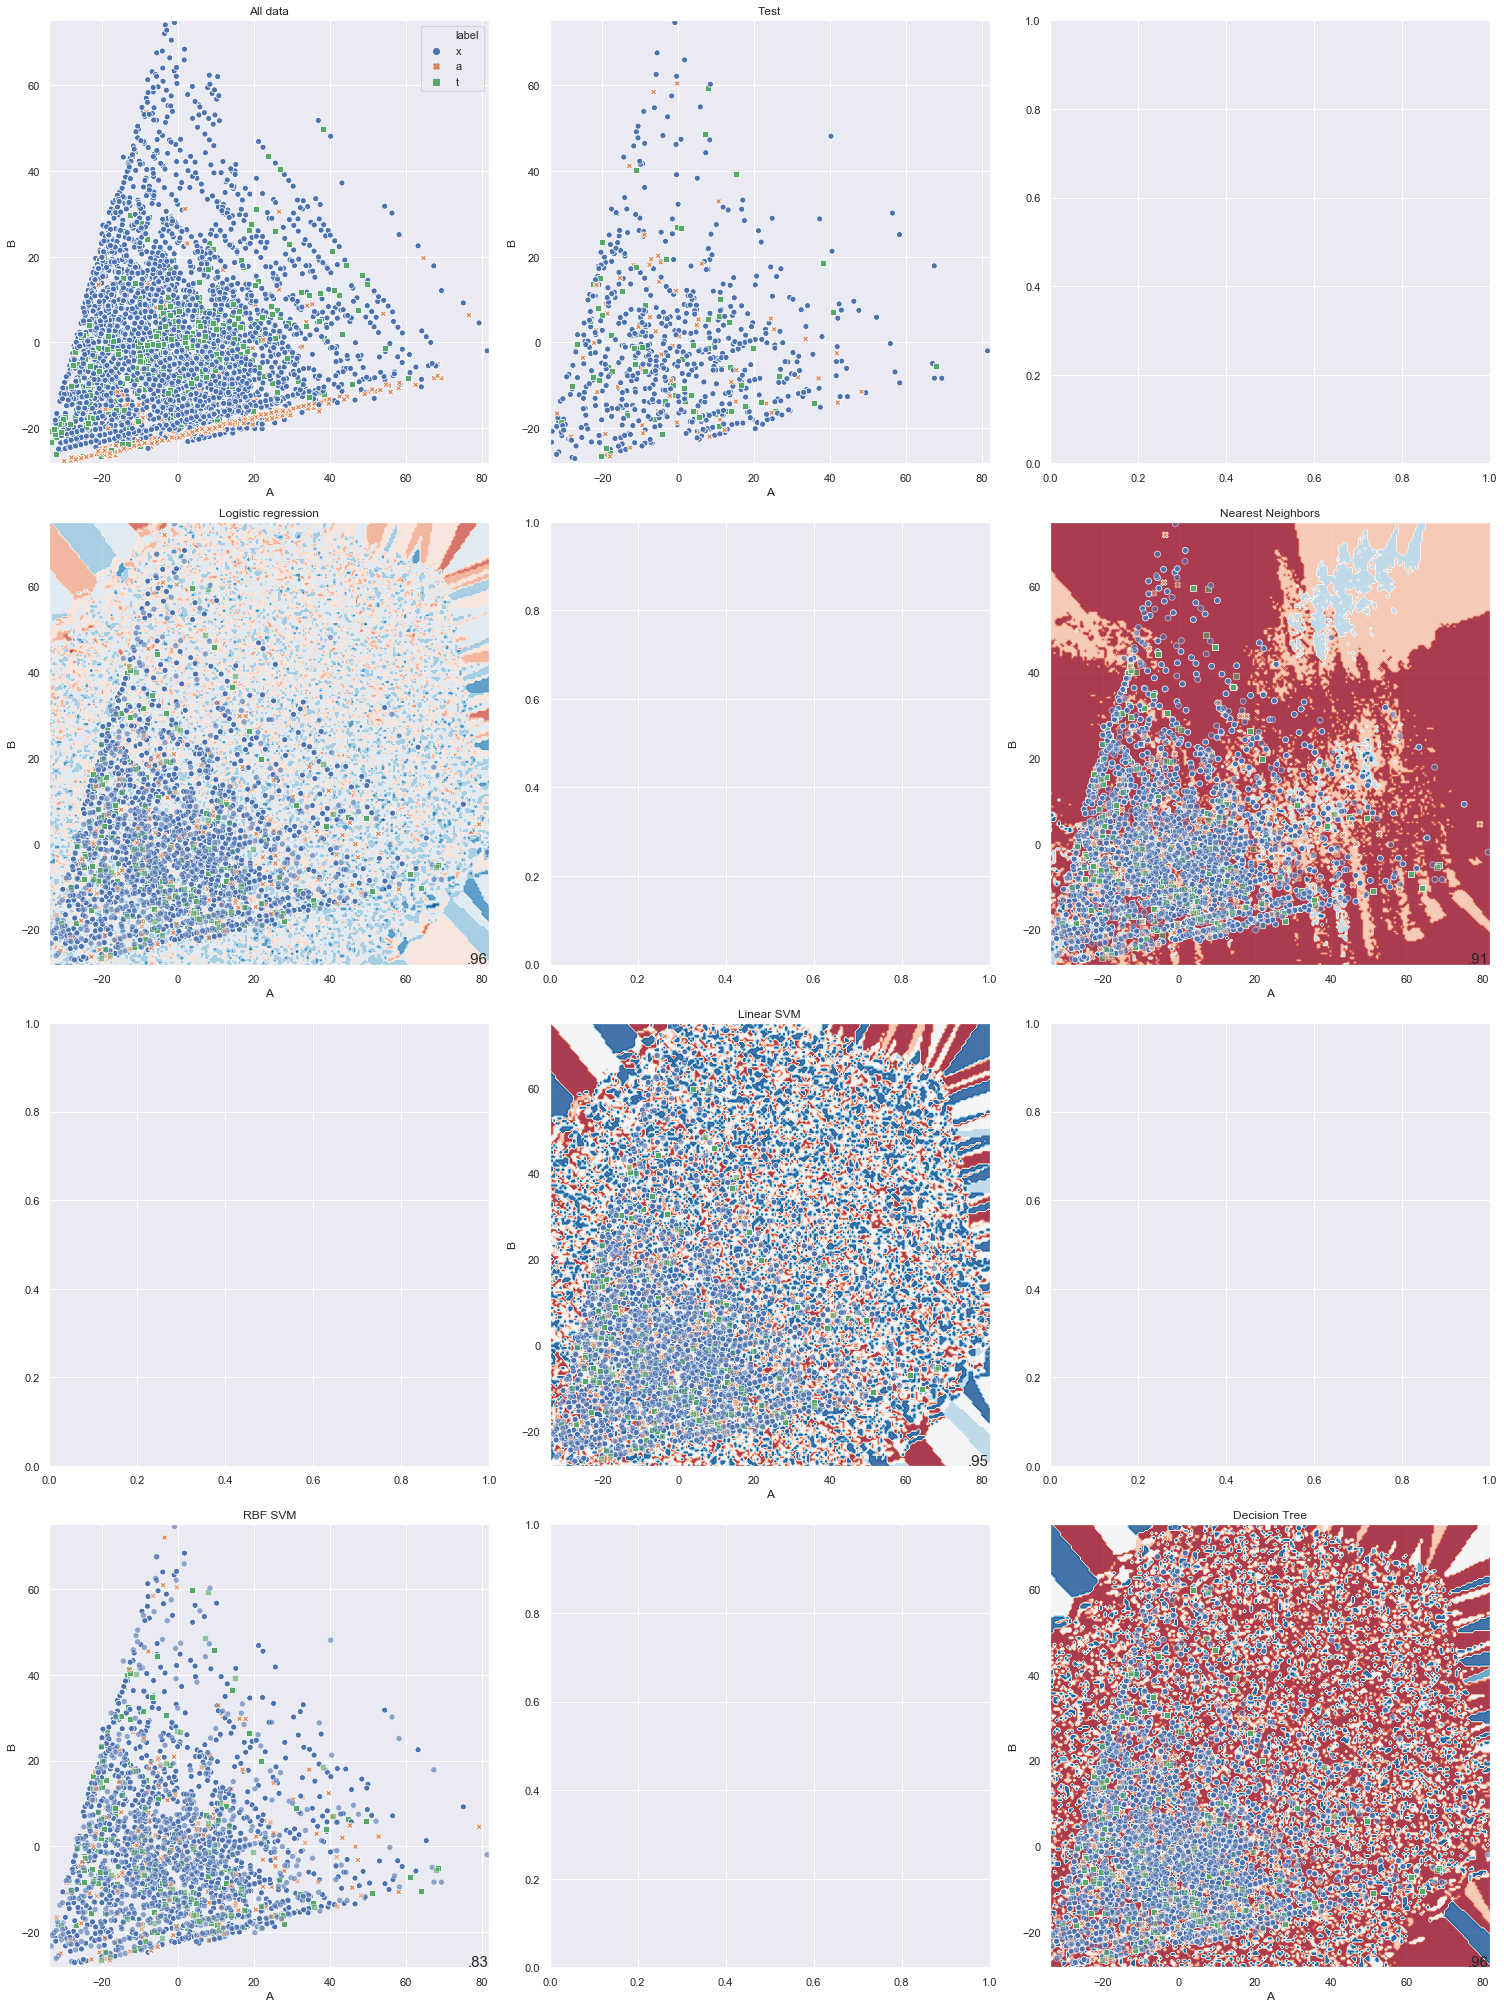

In [8]:
#
# Train, evaluate, and plot
#

cm = plt.cm.RdBu
f, axes = plt.subplots(4, 3, figsize=(21, 28))  # 3 col x 4 rows
axes = axes.ravel()  # unroll this into row-major 1D array
i = 0

# plot full input dataset
plot(X, y, axes[i], "All data", legend="brief")

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

# Plot the test set
i += 1
plot(X_test, y_test, axes[i], "Test", legend=None)

# iterate over classifiers and plot each of them
for name, clf in classifiers:
    i += 1
    i += 1
    # train and print report
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("\n----\n{} (score={:.5f}):".format(name, score))
    print(classification_report(y, clf.predict(X), digits=5))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    try:
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(griddf)[:, 1]
        else:
            Z = clf.predict_proba(griddf)[:, 1]

        # TODO continue here
        # Put the result into a color plot
        zz = np.zeros(xx.shape)
        for index in np.ndindex(zindex.shape):
            zz[index] = Z[zindex[index]]
        axes[i].contourf(xx, yy, zz, cmap=cm, alpha=.8)

        # Plot the training points
        plot(X_train, y_train, axes[i], name, legend=None)
        plot(X_test, y_test, axes[i], name, legend=None, alpha=0.6)
        axes[i].text(x_max-.3, y_min+.3, '{:.2f}'.format(score).lstrip('0'),
                     size=15, horizontalalignment='right')
    except:
        pass # doesn't matter if error

if not False:
    plt.tight_layout()
    plt.show()

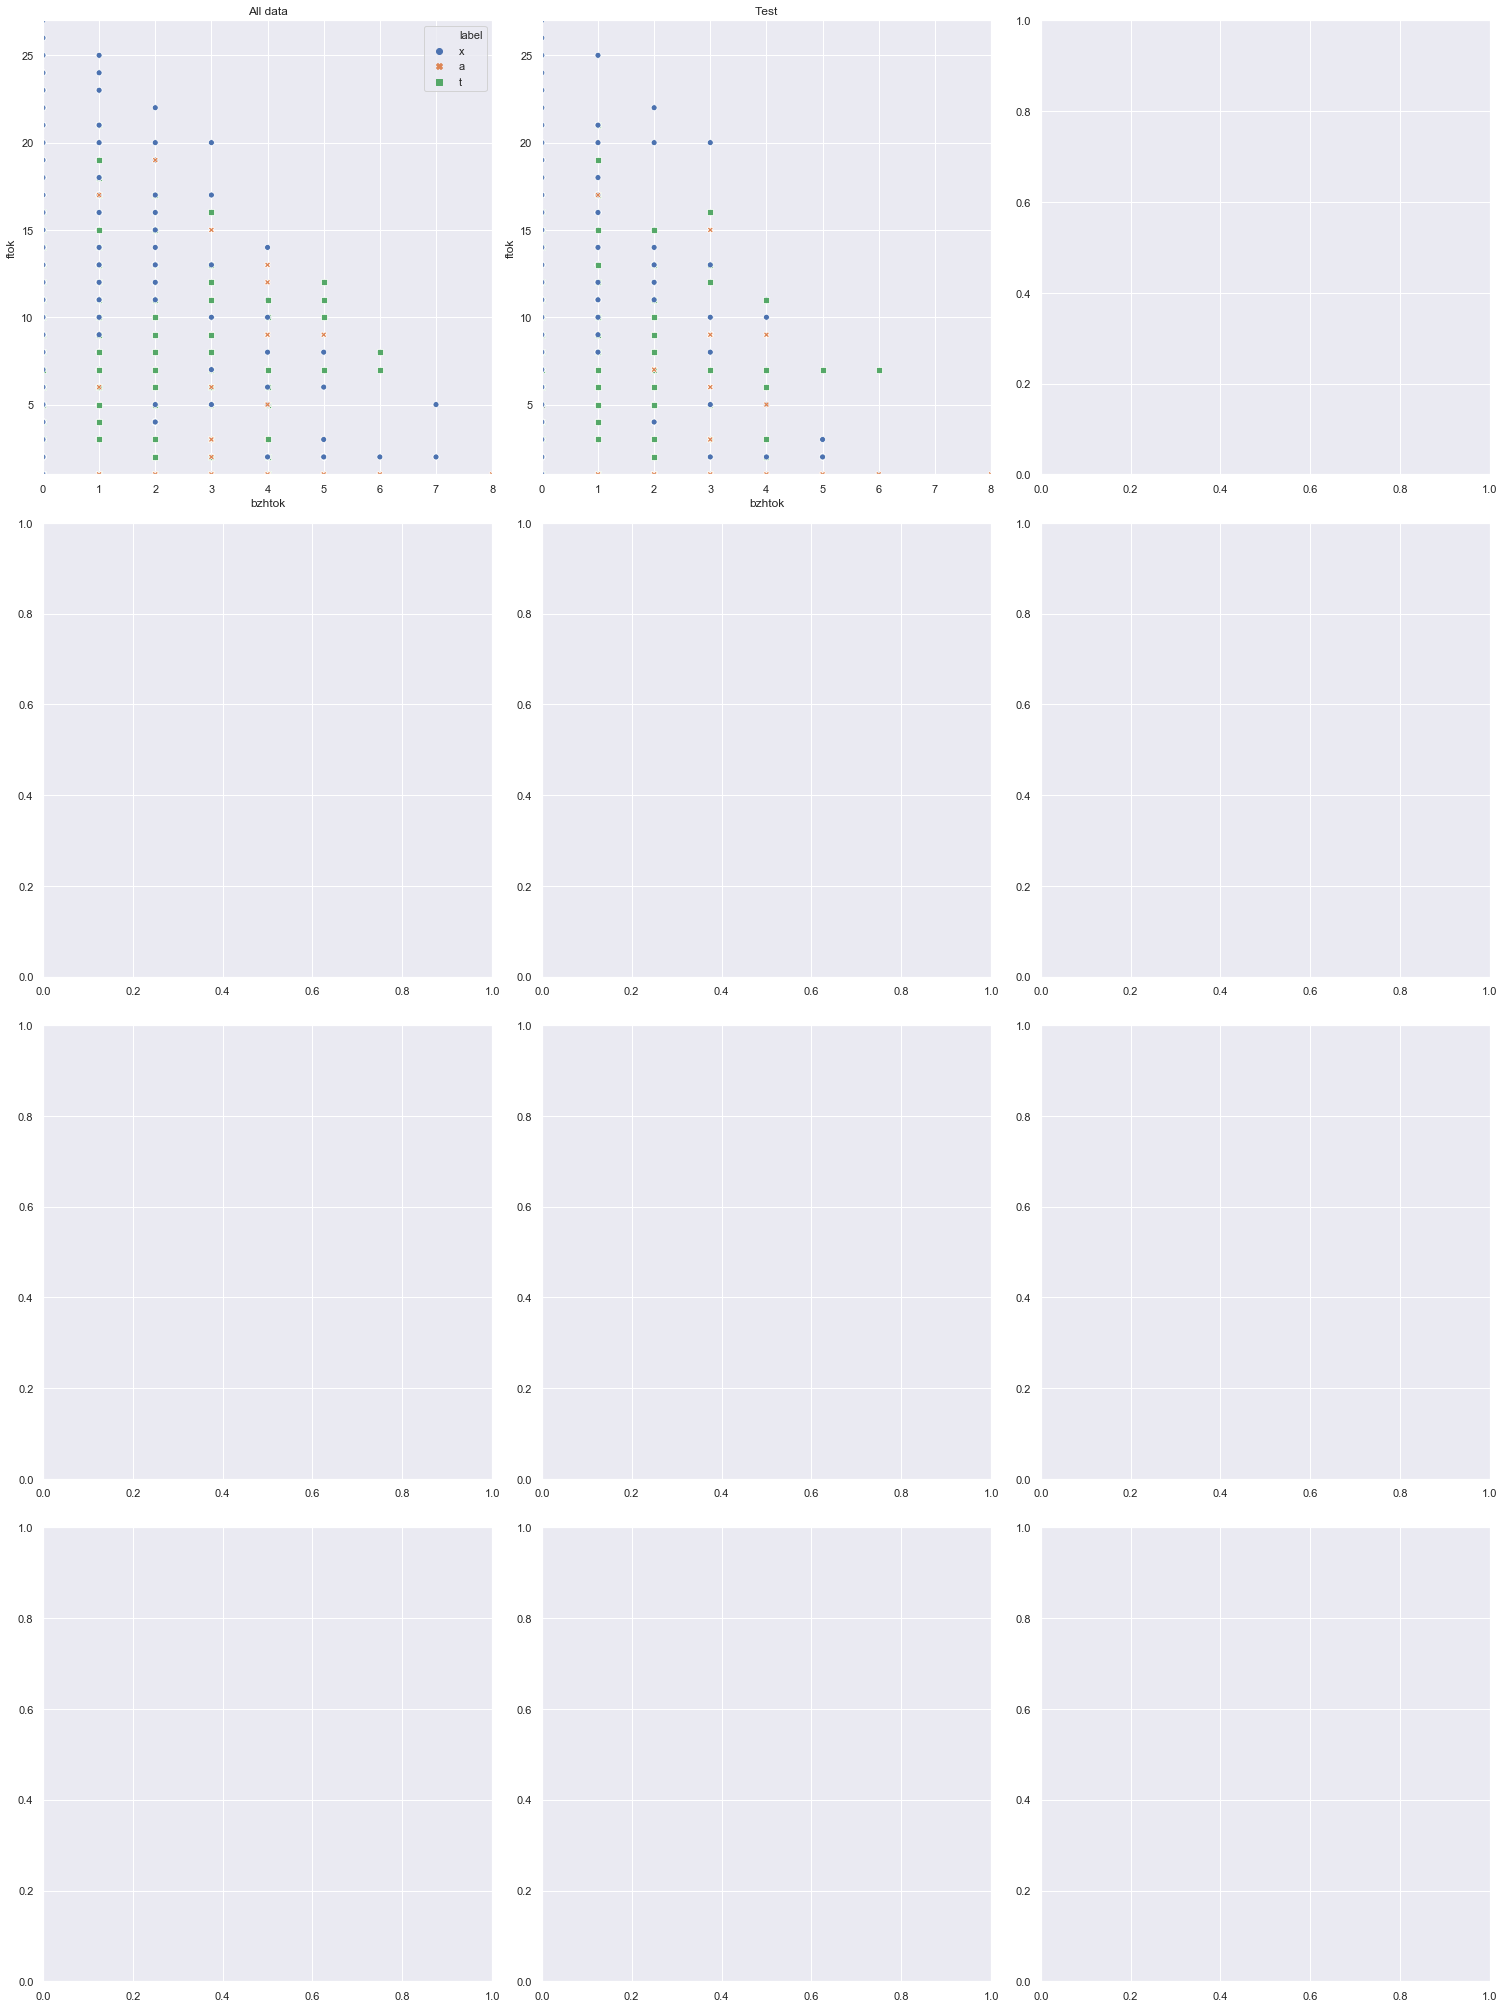

In [25]:
# Plot by two most correlated axis
#

featx, featy = "bzhtok", "ftok"
X = df[[featx, featy]]
y = df['label']

# get size limit of input data, for plotting purpose
x_min, x_max = df[featx].min(), df[featx].max()
y_min, y_max = df[featy].min(), df[featy].max()

# build a meshgrid according to input attributes, for plotting
# this takes a while to complete the last for-loop
ranges = []
for c in incol:
    if c in [featx, featy]:
        ranges.append(np.linspace(df[c].min(), df[c].max(), N))
    else:
        ranges.append(list(df[c].mode()))
# full mesh grid, only the featx and featy axis is scanning from min to max, other features are single sample point
# xx and yy have shape (N, N)
# griddf have shape (N*N, len(incol))
grids = np.meshgrid(*ranges)
griddf = pd.DataFrame(np.column_stack(tuple(g.ravel() for g in grids)), columns=incol)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

# Create plot helper
def plot(X, y, axis, title, **kwargs):
    "Plot PCA-ized X over label Y in 2D scatter plot"
    ax = sns.scatterplot(data=df.filter([featx, featy]).assign(label=y),
                         hue="label", style="label", x=featx, y=featy, ax=axis, **kwargs)
    ax.set_title(title)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# prepare plots
cm = plt.cm.RdBu
f, axes = plt.subplots(4, 3, figsize=(21, 28))  # 3 col x 4 rows
axes = axes.ravel()  # unroll this into row-major 1D array
i = 0

# plot full input dataset,
# reuse the old split of trainning and test sets, reuse the old trained classifiers
plot(X, y, axes[i], "All data", legend="brief")

# Plot the test set
i += 1
plot(X_test, y_test, axes[i], "Test", legend=None)

# iterate over classifiers and plot each of them
for name, clf in classifiers:
    i += 1
    i += 1
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    try:
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(griddf)[:, 1]
        else:
            Z = clf.predict_proba(griddf)[:, 1]

        # Put the result into a color plot
        zz = Z.reshape(xx.shape)
        axes[i].contourf(xx, yy, zz, cmap=cm, alpha=.8)

        # Plot the training points
        plot(X_train, y_train, axes[i], name, legend=None)
        plot(X_test, y_test, axes[i], name, legend=None, alpha=0.6)
        axes[i].text(x_max-.3, y_min+.3, '{:.2f}'.format(score).lstrip('0'),
                     size=15, horizontalalignment='right')
    except:
        pass # doesn't matter if error

if not False:
    plt.tight_layout()
    plt.show()